In [146]:
using CSV, DataFrames
using Optim, NLSolversBase, Random
using Distributions
using LinearAlgebra, GLM


In [147]:
#  Read in Dataset
df = CSV.read("sampledata.csv", DataFrame; header=1, delim=",")

#  append a column of 1 to be used as a constant
df[!, :_cons] .=1;



n = size(df, 1)     # n is number of observations
nvar = size(df, 2)  # nvar is number of variable 

describe(df)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,yvar,7.27812,3.58666,7.28586,9.80335,0,Float64
2,Lland,1.05695,-1.60944,1.14307,3.04309,0,Float64
3,PIland,0.146997,0.0,0.0,1.0,0,Float64
4,Llabor,6.84951,3.2581,6.72263,9.46622,0,Float64
5,Lbull,5.64161,2.07944,5.68358,8.37008,0,Float64
6,Lcost,4.6033,0.0,5.1511,8.73311,0,Float64
7,yr,5.38007,1,5.0,10,0,Int64
8,age,53.8856,26,53.0,90,0,Int64
9,school,2.02583,0,0.0,10,0,Int64


In [148]:
# get sfmodel maximum likelyhood function
function sfmodel_spec(dist, depvar, frontier, log_σ_u_ED, β, log_σ_v, log_σ_u_ME)
    """
    dist: distribution of u_i and v_i
    depvar: depend variable with matrix or Dataframe type
    frontier: independent variable with matrix or Dataframe type
    log_σ_u_ED: exogenous determinant of log_σ_u with matrix or Dataframe type
    β: marginal effect for depvar vector with length equal to columns of frontier with matrix or DataFrame type
    log_σ_v: float type
    log_σ_u_ME: marginal effect for log_σ_u_ED with length equal to columns of log_σ_u_ED
    """ 
    
    
    if dist == "half"
        d = Normal(0, 1)
    end
    
    X = convert(Matrix, frontier)
    Y = vec(depvar)
    W_u = convert(Matrix, log_σ_u_ED)
    ε = vec(Y - X*β)  #  ε is residual vector  !! some error occur
    
    n = size(X, 1)  # n is number of observation
    
    σ_u = map(exp, (W_u*log_σ_u_ME))  # σ_u is vector contain each observation's variance of efficiency
    σ_v = exp(log_σ_v)
    
    tmp = vec(map(σ_ui -> 1/2*log(σ_ui^2 + σ_v), σ_u))
    u_star = vec((-σ_u.^2 .*ε)./(σ_v^2 .+ σ_u.^2))
    sigma_star = vec(map(σ_ui -> (σ_v^2*σ_ui^2)/(σ_v^2 + σ_ui^2), σ_u))
    
    tmp_2 = vec(map(t -> log(pdf(d, t)), ε./(((σ_u.^2 .+ σ_v^2)).^(1/2))))
    
    
    llike_i = -log(1/2) .- tmp .+ tmp_2 .+ map(t -> log(cdf(d, t)), u_star./(sigma_star) .^(1/2))
    llike = sum(-1 .*llike_i)  # sum up llike_i
    
end


sfmodel_spec (generic function with 1 method)

In [149]:
# take imput data

y = df.yvar
x = df[:,["Lland", "PIland", "Llabor", "Lbull", "Lcost", "yr", "_cons"]]
log_σ_u_ED = df[:, ["age", "school", "yr", "_cons"]]


nvar = size(x, 2)    # number of xvar
println(nvar)
n_ED = size(log_σ_u_ED, 2)  # number of exogenous determinant of log_σ_u



7


4

In [150]:
# since β is consistent in both OLS and SF model, I run OLS to get β coefficient as initial value

fm = @formula(yvar ~ Lland + PIland + Llabor + Lbull + Lcost + yr + _cons)
linearRegressor = lm(fm, df[:,["yvar", "Lland", "PIland", "Llabor", "Lbull", "Lcost", "yr", "_cons"]])
print(linearRegressor)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

yvar ~ 1 + Lland + PIland + Llabor + Lbull + Lcost + yr + _cons

Coefficients:
──────────────────────────────────────────────────────────────────────────────────
                   Coef.    Std. Error       t  Pr(>|t|)    Lower 95%    Upper 95%
──────────────────────────────────────────────────────────────────────────────────
(Intercept)   0.877344      0.363618      2.41    0.0165    0.161383     1.59331
Lland         0.273592      0.0744712     3.67    0.0003    0.126959     0.420225
PIland        0.108956      0.197265      0.55    0.5812   -0.279457     0.497369
Llabor        1.26251       0.0823367    15.33    <1e-37    1.10039      1.42463
Lbull        -0.50067       0.0617097    -8.11    <1e-13   -0.622176    -0.379164
Lcost         0.00177811    0.0145402     0.12    0.9028   -0.0268514    0.0304076
yr            0.0

In [151]:
initial_value = [0.273592, 0.108956, 1.26251, -0.50067, 0.00177811, 0.049151, 0.877344, 0.108956, 0.108956, 0.108956, 0.108956, 0.108956]
println(size(initial_value))
func = TwiceDifferentiable(vars -> sfmodel_spec("half", y, x, log_σ_u_ED,
                                                              vars[1:nvar], vars[nvar+1], vars[nvar+2:nvar+n_ED+1]),
                                                              initial_value; autodiff=:forward);
opt = optimize(func, initial_value)

(12,)


 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     1.010886e+02

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 6.69e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.21e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.16e-07 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.15e-09 ≰ 0.0e+00
    |g(x)|                 = 8.38e+00 ≰ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    3110
    ∇f(x) calls:   3110
    ∇²f(x) calls:  1001


In [152]:
parameters = Optim.minimizer(opt)
parameters[nvar+1] = exp(parameters[nvar+1])  # σ_v estimation

# build up β_table
β = parameters[1:nvar]
frontier_name = ["Lland", "PIland", "Llabor", "Lbull", "Lcost", "yr", "_cons"]
β_table = convert(DataFrame, [frontier_name β])
rename!(β_table, ["variable_name", "β"])

,variable_name,β
,Any,Any
1,Lland,0.17536
2,PIland,0.249209
3,Llabor,1.06722
4,Lbull,-0.287234
5,Lcost,0.0226944
6,yr,0.00390032
7,_cons,1.85395


In [153]:
ED_names = ["age", "school", "yr", "_cons"]
log_σ_u_ED_table = convert(DataFrame, [ED_names parameters[nvar+2:end]])
rename!(log_σ_u_ED_table, ["variable_name", "coefficient"])

,variable_name,coefficient
,Any,Any
1,age,-0.00277744
2,school,-0.0176864
3,yr,-0.0616731
4,_cons,0.164519


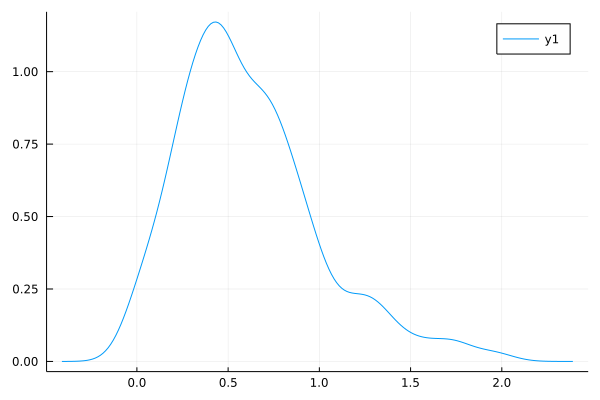

In [154]:
# build up efficiency variance table

dist = Normal(0, 1)
σ_u = map(t->exp(t), convert(Matrix, df[:, ED_names]) * parameters[nvar+2:end])  # vector of estimation of σ_u
σ_v = parameters[nvar+1]
β = parameters[1:nvar]
x = convert(Matrix, x) 
ε = vec(y - x*β)

u_star = vec((-σ_u.^2 .*ε)./(σ_v^2 .+ σ_u.^2))
sigma_star = vec(map(σ_ui -> (σ_v^2*σ_ui^2)/(σ_v^2 + σ_ui^2), σ_u))
tmp = u_star ./(sigma_star .^(1/2))

# Exp_u_i is expectation of u_i condition on ε_i
Exp_u_i = sigma_star .^(1/2) .*map(t->pdf(dist, t), tmp) ./(map(t->cdf(dist, t), tmp)) .+ u_star   

density(vec(Exp_u_i))